In [1]:
import pandas as pd
from datetime import datetime
from numpy import log2
import os

ESTIM_DIR = "estims"
PRICE_DIR = "prices"

START_DT = datetime(2015, 1, 1)
END_DT = datetime(2020, 12, 31)
SMP_TICKERS_BY = 5

MIN_DATA_POINTS = 50
MAX_GAP_DAYS = 120
MAX_PRICE_RATIO = 20

SMOOTH_EMA = 5
PRICE_EMA = 60
ESTIM_EMA = 90
PRICE_EQUITY = True
ESTIM_EQUITY = True
CONTRA_ESTIM = False

UPSIDE_DAYS = 60

MIN_CORR_LAG = -2
MAX_CORR_LAG = 3
CORR_LAG_STEP = "30D"
MIN_CORR_COEF = 0.4

EXAMPLES = ["AAPL", "ABT", "APO", "COP", "CP", "DOV", "MAR", "ROP", "TROW", "TXT", "VRSK", "WCN", "WYNN"]

def load_tickers(fname):
    tickers = pd.read_csv(fname, sep=' ', index_col=0, names=["Ticker","Size"])
    return tickers[tickers["Size"] >= MIN_DATA_POINTS].index.tolist()

def load_data(fname, colname):
    data = pd.read_csv(fname, sep=' ', parse_dates=[0], index_col=0, names=["Date", colname])
    return data[(data.index >= START_DT) & (data.index <= END_DT)]

def equity(x):
    d = x.pct_change()
    d[0] = 0
    return (d * 100).cumsum() + 100

def interp(x):
    dts = pd.date_range(x.index[0], x.index[-1])
    return x.reindex(dts).interpolate(method="linear").dropna()

def plot_pr_es(data, tk):
    if tk in data:
        data[tk][["Price", "Estim"]].plot()


In [2]:

# build tickers list
price_tks = load_tickers(os.path.join(PRICE_DIR, "tickers.lst"))
print("{} tickers with prices".format(len(price_tks)))

estim_tks0 = load_tickers(os.path.join(ESTIM_DIR, "0", "tickers.lst"))
print("{} tickers with Y0-estims".format(len(estim_tks0)))

estim_tks1 = load_tickers(os.path.join(ESTIM_DIR, "1", "tickers.lst"))
print("{} tickers with Y1-estims".format(len(estim_tks1)))

all_tickers = sorted(list(set(estim_tks0) & set(estim_tks1)))
print("{} tickers available".format(len(all_tickers)))

tickers = [x for i, x in enumerate(all_tickers) if i % SMP_TICKERS_BY == 0 or x in EXAMPLES]
print("{} tickers sampled".format(len(tickers)))


1799 tickers with prices
1516 tickers with Y0-estims
1617 tickers with Y1-estims
1510 tickers available
311 tickers sampled


In [3]:
# load prices
prices = {tk: load_data(os.path.join(PRICE_DIR, tk + ".txt"), "Price") for tk in tickers}
prices["AAPL"].head(5)


Price
Date               
2015-01-02  115.456
2015-01-09  118.286
2015-01-16  111.929
2015-01-23  119.311
2015-01-30  123.725

In [4]:
# load estims
estims = {}
for tk in tickers:
    es0 = load_data(os.path.join(ESTIM_DIR, "0", tk + ".txt"), "Es0")
    es1 = load_data(os.path.join(ESTIM_DIR, "1", tk + ".txt"), "Es1")
    d = pd.concat([es0, es1], axis=1)
    # use day-of-year weighted mean of es0 (this year) and es1 (next year)
    w = es1.index.to_series().dt.dayofyear / 366
    d["Estim"] = es0["Es0"] * (1.0 - w) + es1["Es1"] * w
    estims[tk] = d.dropna()

estims["AAPL"].head(5)

Es0         Es1          Estim
Date                                             
2015-01-02  211834.698  225142.526  211907.418372
2015-01-09  211861.140  225203.632  212189.234066
2015-01-16  212553.070  226123.105  213146.295574
2015-01-23  212850.163  225622.474  213652.794566
2015-01-30  224009.140  234732.310  224888.088361

In [5]:
# find longest gaps for tickers
gaps = {}
for tk in tickers:
    d = estims[tk].index.to_series().diff()
    gaps[tk] = { "Gap": d.max().days, "Date": d.idxmax() }
gaps = pd.DataFrame(data=gaps).T
gaps.index.name = "Ticker"
gaps.head(5)

Gap       Date
Ticker               
A       77 2018-01-05
AAP     49 2019-10-04
AAPL    70 2017-01-06
ABBV    63 2017-04-07
ABT     91 2019-10-18

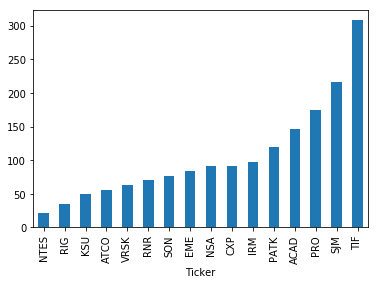

In [6]:
# See how longest gap value distributed
gaps["Gap"].sort_values().iloc[::20].plot.bar()


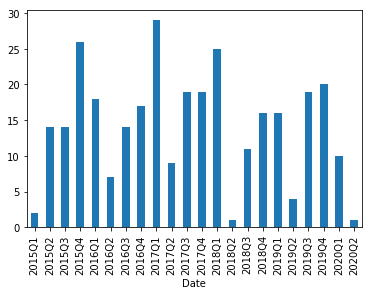

In [7]:
# See where the longest gaps happened
gaps.groupby(gaps["Date"].dt.to_period("Q")).size().plot.bar()

In [8]:
# filter tickers by gaps
tickers = gaps[gaps["Gap"] <= MAX_GAP_DAYS].index.tolist()
print("{} tickers with not long gap".format(len(tickers)))


222 tickers with not long gap


In [9]:
# filter tickers with huge price diff
rminmax = []
for tk in tickers:
    m = prices[tk]["Price"].min()
    M = prices[tk]["Price"].max()
    rminmax.append({"Ticker": tk, "Ratio": log2(M / m)})

rminmax = pd.DataFrame(rminmax).set_index("Ticker").sort_values(by="Ratio")

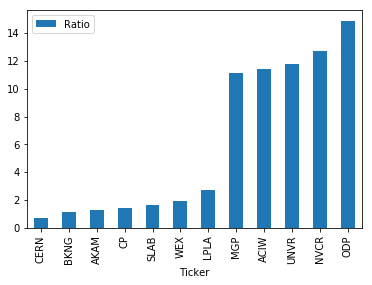

In [10]:
rminmax.iloc[::20].plot.bar()

In [11]:
tickers = rminmax[rminmax["Ratio"] < log2(MAX_PRICE_RATIO)].index.tolist()
print("{} tickers with not big price ratio".format(len(tickers)))

127 tickers with not big price ratio


In [12]:
# calc price vs estim

def calc_price_vs_estim(prices, estims):
    data = pd.DataFrame()
    # smoothen prices
    data["Price"] = prices["Price"].ewm(span=SMOOTH_EMA).mean()
    if PRICE_EQUITY:
        # # normalize prices to 100% scale by equity
        data["Price"] = equity(data["Price"])
    else:
        # normalize prices to 100% scale by first value
        data["Price"] = data["Price"] / data["Price"].iloc[0] * 100
    # calc long-term mean for price
    data["MeanPr"] = data["Price"].ewm(span=PRICE_EMA).mean()
    # calc rel dev for price mean
    data["DevPr"] = (data["Price"] - data["MeanPr"]) / data["MeanPr"]
    # smoothen estims
    data["Estim"] = estims["Estim"].ewm(span=SMOOTH_EMA).mean()
    if ESTIM_EQUITY:
        # normalize estims to 100% scale by equity
        data["Estim"] = equity(data["Estim"])
    else:
        # normalize estim to 100% scale by first value
        data["Estim"] = data["Estim"] / data["Estim"].iloc[0] * 100
    # calc long-term mean for estim
    data["MeanEs"] = data["Estim"].ewm(span=ESTIM_EMA).mean()
    # calc rel dev for estim
    data["DevEs"] = (data["Estim"] - data["MeanEs"]) / data["MeanEs"]
    if CONTRA_ESTIM:
        data["DevEs"] = -data["DevEs"]
    return data

price_vs_estim = {tk: calc_price_vs_estim(prices[tk], estims[tk]) for tk in tickers }

price_vs_estim["AAPL"].head(5)

Price      MeanPr     DevPr       Estim      MeanEs     DevEs
Date                                                                          
2015-01-02  100.000000  100.000000  0.000000  100.000000  100.000000  0.000000
2015-01-09  101.470690  100.747601  0.007177  100.079794  100.040340  0.000394
2015-01-16   99.358086  100.268906 -0.009084  100.318737  100.135209  0.001833
2015-01-23  101.035866  100.470338  0.005629  100.527724  100.236633  0.002904
2015-01-30  103.380586  101.091826  0.022640  102.665058  100.744141  0.019067

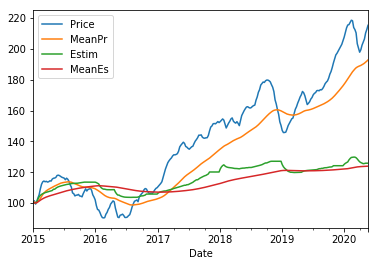

In [13]:
price_vs_estim["AAPL"][["Price", "MeanPr", "Estim", "MeanEs"]].plot()


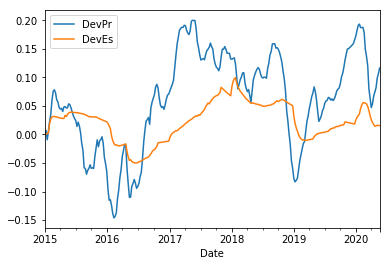

In [14]:
price_vs_estim["AAPL"][["DevPr", "DevEs"]].plot()


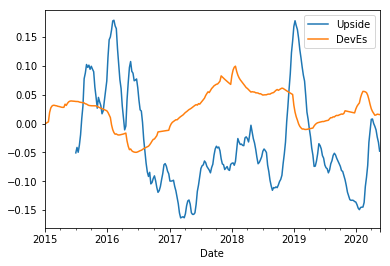

In [15]:
# calc upside
for tk in tickers:
    p = interp(price_vs_estim[tk]["Price"])
    f1 = p.shift(periods=UPSIDE_DAYS, freq="1D")
    f2 = p.shift(periods=2*UPSIDE_DAYS, freq="1D")
    f3 = p.shift(periods=3*UPSIDE_DAYS, freq="1D")
    f = (f1 + f2 + f3) / 3
    price_vs_estim[tk]["Upside"] = ((f - p) / p).dropna()

price_vs_estim["AAPL"][["Upside", "DevEs"]].plot()

In [16]:
# calc DevEs vs upside corr
ucorr = []
for tk in tickers:
    p = interp(price_vs_estim[tk]["DevEs"])
    u = interp(price_vs_estim[tk]["Upside"])
    ucorr.append({"Ticker": tk, "Corr": p.corr(u)})

ucorr = pd.DataFrame(ucorr).set_index("Ticker").sort_values(by="Corr", ascending=False)

ucorr.head(10)

Corr
Ticker          
LSI     0.561989
INGR    0.335222
TYL     0.283521
BCPC    0.255190
PM      0.234088
HII     0.229901
FFIV    0.224129
CME     0.214774
WWW     0.152005
LECO    0.103067

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c0115a6d0>]],
      dtype=object)

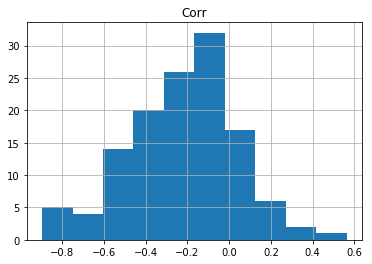

In [17]:
ucorr.hist()

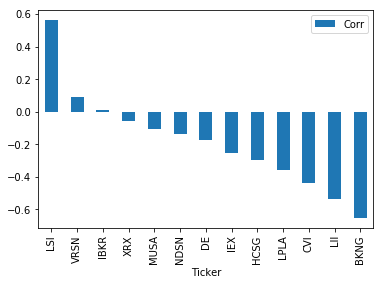

In [18]:
ucorr.iloc[::10].plot.bar()

In [19]:
def corrs_with_lag(x, y):
    rng = list(range(MIN_CORR_LAG, MAX_CORR_LAG+1))
    corr = [x.corr(y.shift(periods=d, freq=CORR_LAG_STEP)) for d in rng]
    return pd.DataFrame(data={"Shift": rng, "Corr": corr}).set_index("Shift")

# calc DevEs vs DevPr corr with different lag
corrs = []
for tk in tickers:
    d = interp(price_vs_estim[tk])
    corrs.append(corrs_with_lag(d["DevPr"], d["DevEs"]))
corrs = pd.concat(corrs, axis=1)
corrs.columns = tickers


In [20]:
x = corrs.iloc[:,:10]
x.style.background_gradient(cmap='Blues', vmin=x.min().min(), vmax=x.max().max())


In [21]:
# calc worst corr among lags
min_corrs = corrs.apply(lambda col: col.loc[MIN_CORR_LAG:MAX_CORR_LAG].min())
ok_tickers = min_corrs.index[min_corrs > 0].tolist()
print("{} tickers with not low corr".format(len(ok_tickers)))


79 tickers with not low corr


In [22]:
# sort columns by rows (lexicographically, higher lag matters more)
sorted_corrs = corrs[ok_tickers]
for i in range(MIN_CORR_LAG, MAX_CORR_LAG+1):
    sorted_corrs = sorted_corrs.sort_values(by=i, axis=1, kind="mergesort", ascending=False)

x = sorted_corrs.iloc[:,:10]
x.style.background_gradient(cmap='Blues', vmin=x.min().min(), vmax=x.max().max())


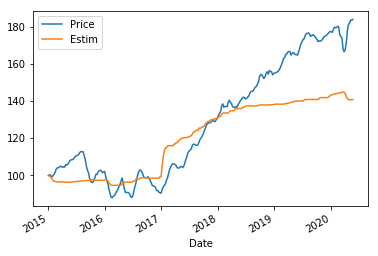

In [23]:
plot_pr_es(price_vs_estim, "ABT")


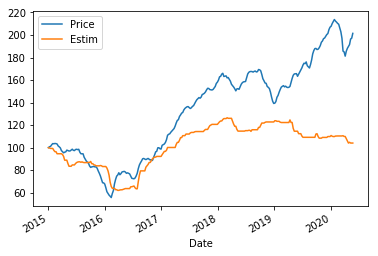

In [24]:
plot_pr_es(price_vs_estim, "APO")


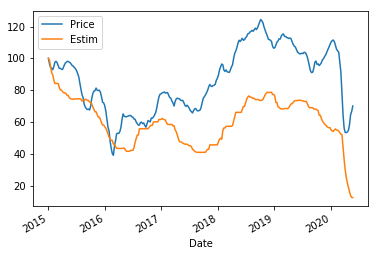

In [25]:
plot_pr_es(price_vs_estim, "COP")

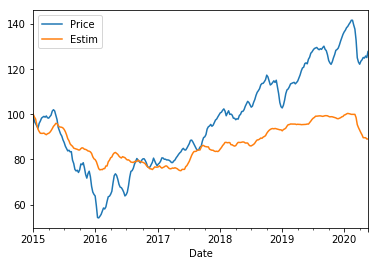

In [26]:
plot_pr_es(price_vs_estim, "CP")


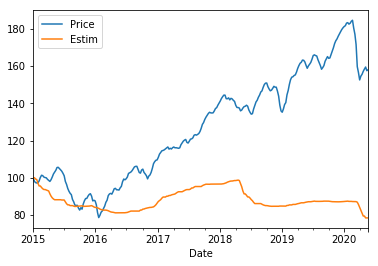

In [27]:
plot_pr_es(price_vs_estim, "DOV")


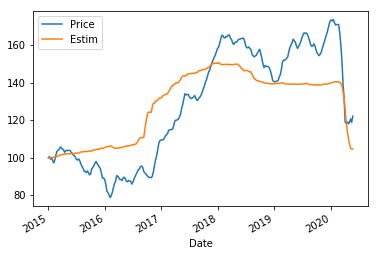

In [28]:
plot_pr_es(price_vs_estim, "MAR")

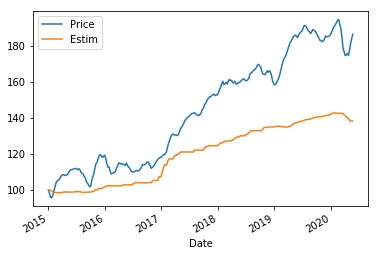

In [29]:
plot_pr_es(price_vs_estim, "ROP")

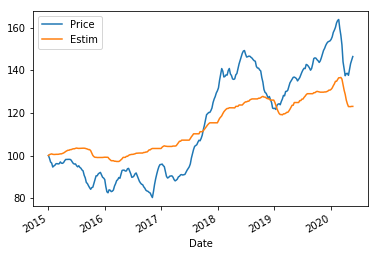

In [30]:
plot_pr_es(price_vs_estim, "TROW")

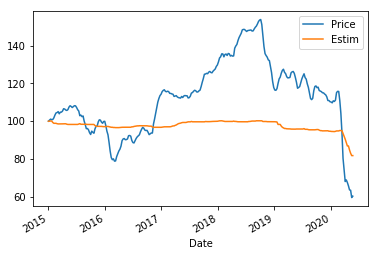

In [31]:
plot_pr_es(price_vs_estim, "TXT")

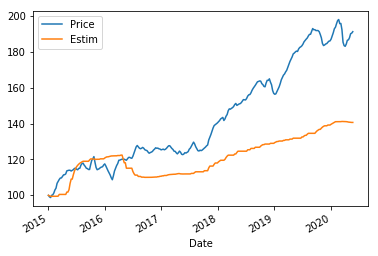

In [32]:
plot_pr_es(price_vs_estim, "VRSK")


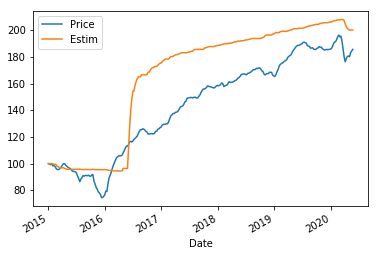

In [33]:
plot_pr_es(price_vs_estim, "WCN")


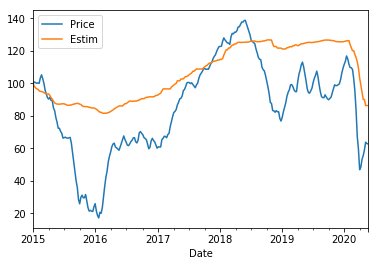

In [34]:
plot_pr_es(price_vs_estim, "WYNN")
